In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from scipy import io
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Prepare Segmentation Dataset

We use Clothing Co-Parsing public dataset as our supervised dataset. This dataset has 1000 images of people (one person per image). There are 1000 label images corresponding to those original images. Label images have 59 segmented classes corresponding to classes such as hair, shirt, shoes, skin, sunglasses and cap. 

Clothing Co-Parsing (CCP) dataset is a new clothing database including elaborately annotated clothing items.

1. 2,098 high-resolution street fashion photos with totally 59 tags

2. Wide range of styles, accessaries, garments, and pose

3. All images are with image-level annotations

4. 1000+ images are with pixel-level annotations

In [2]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 25.01 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.
Checking out files: 100% (4202/4202), done.


In [3]:
!ls clothing-co-parsing/

annotations  label_list.mat  photos	show_image_anno.m
example.jpg  LICENSE	     README.md	show_pixel_anno.m


Input images are in the photos directory, and labelled images are in the annotations directory. Let’s extract the input images from the respective source directory.

In [4]:
images = []
for i in range(1,1001):
    url = './clothing-co-parsing/photos/%04d.jpg'%(i)
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

Let’s extract the labelled images (segmented images) from the respective source directory.

In [5]:
masks = []
for i in range(1,1001):
    url = './clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask)

In [6]:
len(images), len(masks)

(1000, 1000)

There are 1000 images and 1000 labels. Visualize some images to get better insights.

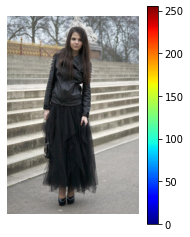

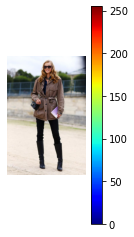

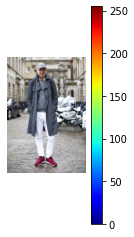

In [7]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.show()

The images are 3-channel colour images with values ranging from 0 to 255. Images seem to have different sizes. We need to scale images and resize them to some common shape. Let’s visualize label images corresponding to the above input images.

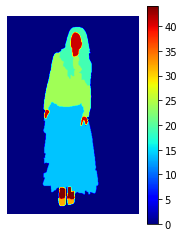

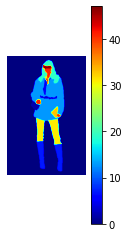

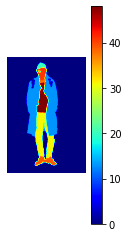

In [8]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.show()

Each colour in the above images refer to a specific class. We observe that the person and her/his wearings are segmented, leaving the surrounding unsegmented. 

In [9]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

# Model Selection

We enter into deep learning now. We have to build a computer vision model that can convert an input image into a segmented image (also called masked image or label image). Building a model from scratch and training it is not a good idea as we have very limited data for training (1000 images are insufficient for 59 unbalanced classes). So we prefer a pre-trained model through transfer learning.

By understanding how semantic segmentation works, we can easily come up with an idea of how to choose our pre-trained model. One of the popular architectural approaches is FCNN (Fully Convolutional Neural Networks). In contrast to CNNs in image classification, where the decision head is made up of dense layers, an FCNN is made up of layers related to convolutional operations only. Because the final output is an image of a shape identical to the input image. 

An FCNN contains two parts: an encoder and a decoder. An encoder is a downstack of convolutional neural layers that extract features from the input image. A decoder is an upstack of transpose convolutional neural layers that builds the segmented image from the extracted features. The sizes of feature maps go down while downsampling (e.g. 128, 64, 32, 16, 8, 4 – in order), and they go up while upsampling (e.g. 4, 8, 16, 32, 64, 128 – in order).

Among FCNNs, U-Net is one of the successful architectures acclaimed for its performance in Medical Image Segmentation. It encourages skip connections between a few specific-sized layers of downstack and upstack. Skip-connections yield better performance because of the truth that upstack struggles to build finer details of the image on its own during upsampling. Skip-connections bye-pass a large stack of layers to feed finer details from a downstack layer to its corresponding upstack layer.

# **U-Net model**


Here, we wish to use the functional approach of U-Net architecture, but we will have our own architecture suitable to our task. The downstack can be a pre-trained CNN, trained for image classification (e.g. MobileNetV2, ResNet, NASNet, Inception, DenseNet, or EfficientNet). It can effectively extract the features. But, we have to build our upstack to match our classes (here, 59), build skip-connections, and train it with our data. 

We prefer a pre-trained DenseNet121 to be the downstack that can be obtained through transfer learning and build the upstack with pix2pix, a publicly available generative upstack template (it saves our time and code).

In [10]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [11]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [12]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [13]:
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [14]:
outputs = tf.keras.layers.Conv2D(59, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

Build the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.

In [16]:
# complete unet model
unet = keras.Model(inputs=inputs, outputs=outputs)

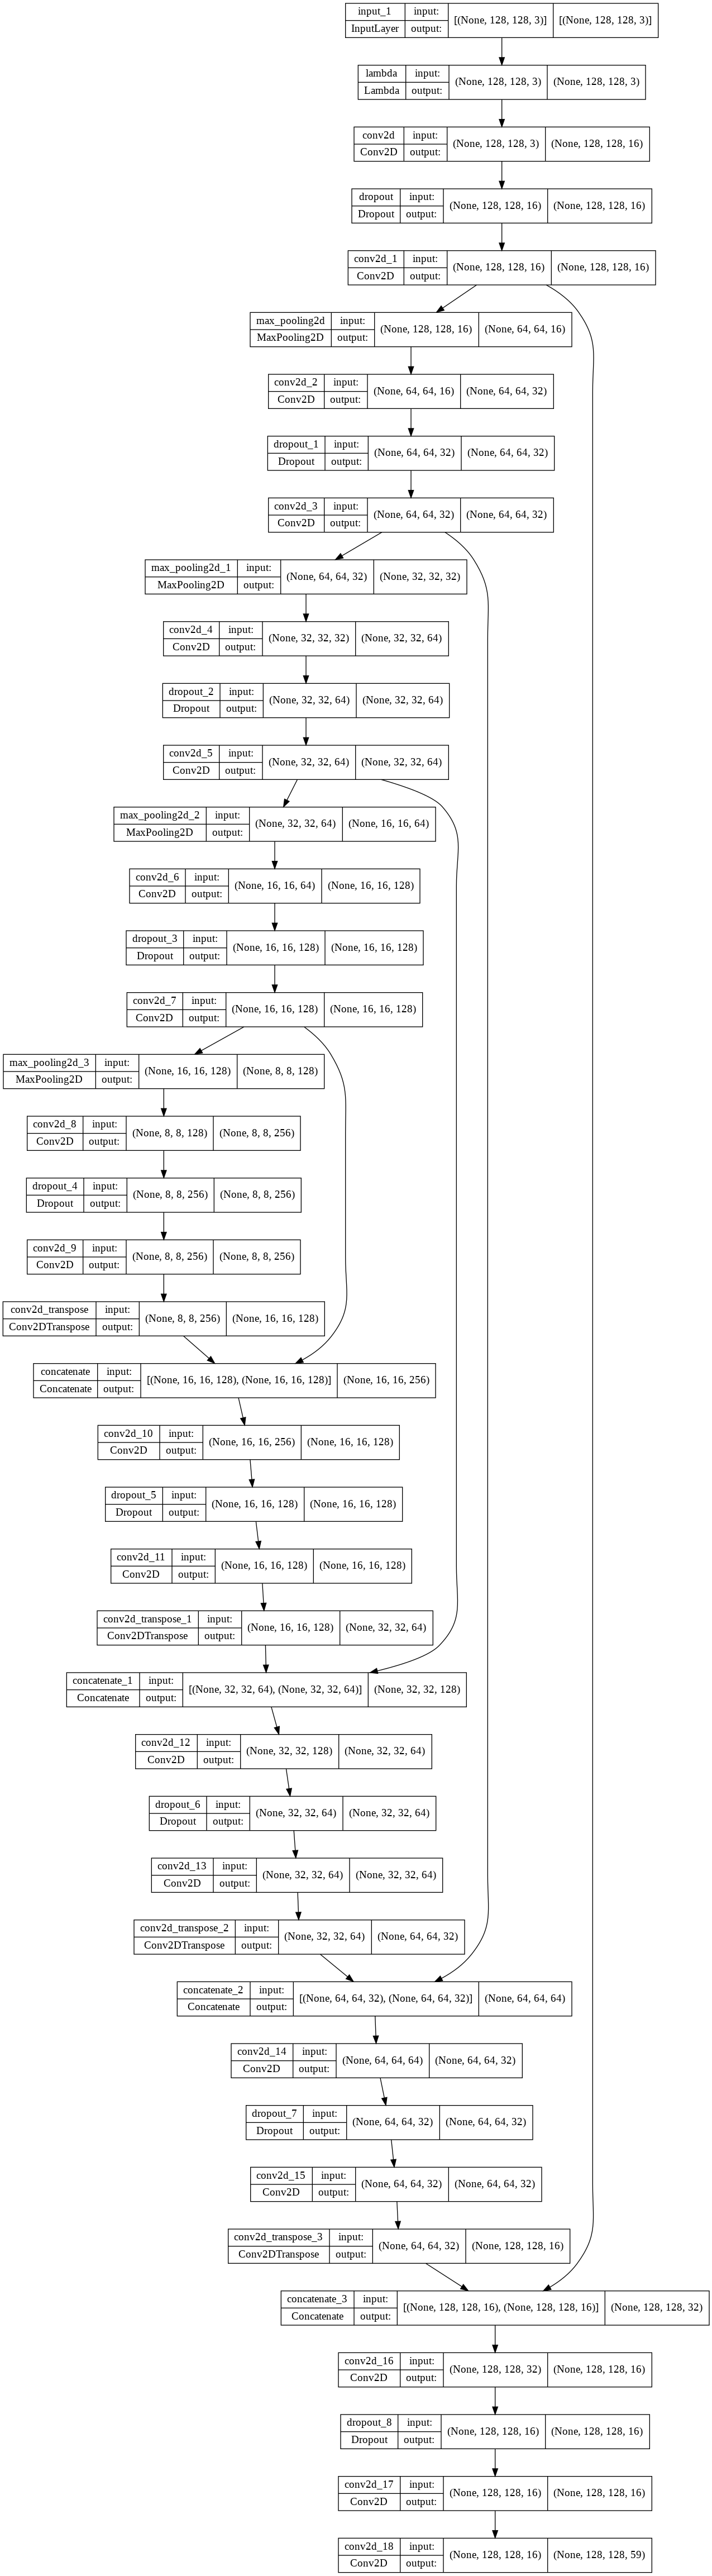

In [17]:
keras.utils.plot_model(unet, show_shapes=True)

# Preprocess Data
The model is perfectly ready. We can start training if data preprocessing is performed. Since we have limited images, we prepare more data through augmentation.

In [18]:
def resize_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
def resize_mask(mask):
     mask = tf.expand_dims(mask, axis=-1)
     mask = tf.image.resize(mask, (128,128))
     mask = tf.cast(mask, tf.uint8)
     return mask

Resize images and masks to the size 128 by 128.

In [19]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks] 

Split the data into train and validation sets.

In [20]:
from sklearn.model_selection import train_test_split
train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=0
                                                      )

In [21]:
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

Zip input images and ground truth masks. 

In [22]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

We have 800 train examples. That’s too low for training. We define a couple of augmentation functions to generate more train examples.

In [23]:
def brightness(img, mask):
     img = tf.image.adjust_brightness(img, 0.1)
     return img, mask
 
def gamma(img, mask):
     img = tf.image.adjust_gamma(img, 0.1)
     return img, mask

def hue(img, mask):
     img = tf.image.adjust_hue(img, -0.1)
     return img, mask

def crop(img, mask):
     img = tf.image.central_crop(img, 0.7)
     img = tf.image.resize(img, (128,128))
     mask = tf.image.central_crop(mask, 0.7)
     mask = tf.image.resize(mask, (128,128))
     mask = tf.cast(mask, tf.uint8)
     return img, mask

def flip_hori(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

def flip_vert(img, mask):
     img = tf.image.flip_up_down(img)
     mask = tf.image.flip_up_down(mask)
     return img, mask

def rotate(img, mask):
     img = tf.image.rot90(img)
     mask = tf.image.rot90(mask)
     return img, mask

Apply augmentation to the data with the above functions. With 7 augmentation functions and 800 input examples, we can get 7*800 = 5600 new examples. Including original examples, we get 5600+800 = 6400 examples for training. That sounds good

In [24]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

In [25]:
# perform augmentation on train data only
a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b) 
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

Prepare data batches. Shuffle the train data

In [26]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

# Train the Model
Let’s check whether everything is good with the data and the model by sampling one example image and predict it with the untrained model.

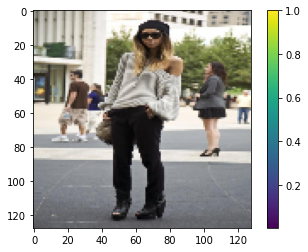

In [27]:
example = next(iter(train))
preds = unet(example[0])
plt.imshow(example[0][60])
plt.colorbar()
plt.show()

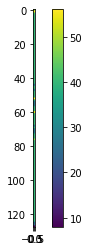

In [28]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0][60])
plt.colorbar()

Compile the model with RMSprop optimizer, Sparse Categorical Cross-entropy loss function and accuracy metric. Train the model for 20 epochs.

In [29]:
unet.compile(loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=keras.optimizers.RMSprop(lr=0.001),
             metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [30]:
hist = unet.fit(train,
                validation_data=val,
                steps_per_epoch=STEPS_PER_EPOCH,
                validation_steps=VALIDATION_STEPS,
                epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/12 [==============================] - 156s 12s/step - loss: 320.1897 - accuracy: 0.3893 - val_loss: 3.3418 - val_accuracy: 0.6264
Epoch 2/5
12/12 [==============================] - 147s 12s/step - loss: 2.8380 - accuracy: 0.5467 - val_loss: 3.1862 - val_accuracy: 0.7039
Epoch 3/5
12/12 [==============================] - 145s 12s/step - loss: 2.3489 - accuracy: 0.6274 - val_loss: 1.9138 - val_accuracy: 0.7500
Epoch 4/5
12/12 [==============================] - 150s 13s/step - loss: 2.1405 - accuracy: 0.6461 - val_loss: 1.9869 - val_accuracy: 0.7578
Epoch 5/5
12/12 [==============================] - 149s 12s/step - loss: 1.9651 - accuracy: 0.6724 - val_loss: 2.1714 - val_accuracy: 0.7631


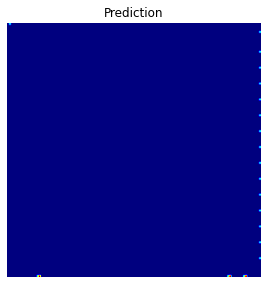

In [31]:
img, mask = next(iter(val))
pred = unet.predict(img)

plt.figure(figsize=(10,5))
for i in pred:
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break

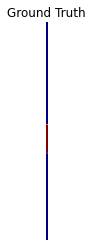

In [32]:
plt.subplot(122)
plt.imshow(mask[0][12], cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()

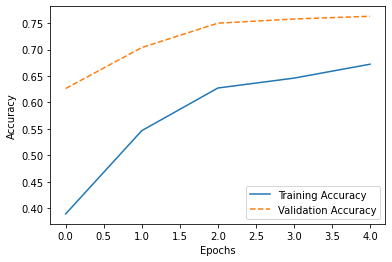

In [33]:
history = hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']
plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()